In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Number of days for this dataset
n_days = 365*200

In [3]:
# Generate random binary values
breakfast_gluten = np.random.randint(2, size=n_days)
morning_tea_milk = np.random.randint(2, size=n_days)
lunch_gluten = np.random.randint(2, size=n_days)
afternoon_tea_milk = np.random.randint(2, size=n_days)
dinner_gluten = np.random.randint(2, size=n_days)
toilet_diarrhea = np.random.randint(2, size=n_days)

In [4]:
# Create dataframe
df_daily = pd.DataFrame({
#     'Day': range(1, n_days + 1),
    'Breakfast': breakfast_gluten,
    'Morning_Tea': morning_tea_milk,
    'Lunch': lunch_gluten,
    'Afternoon_Tea': afternoon_tea_milk,
    'Dinner': dinner_gluten,
    'Toilet': toilet_diarrhea
})

In [5]:
df_daily = df_daily.replace({True: 1, False: 0})


In [6]:
df_daily.at[0, 'Toilet'] = 0
# Create a new column that is the sum of the other columns
df_daily['sum'] = df_daily[['Breakfast', 'Morning_Tea', 'Lunch', 'Afternoon_Tea', 'Dinner']].sum(axis=1)

# If 'sum' at row t is not 0, set 'Toilet' at row t+1 to 1
df_daily['Toilet'] = (df_daily['sum'].shift(-1) != 0).astype(int)

# Drop the 'sum' column as we don't need it anymore
df_daily.drop('sum', axis=1, inplace=True)

In [7]:
df_daily.shape

(73000, 6)

In [8]:
df_daily = df_daily.astype(int)

In [9]:
df_daily.head(10)

,Breakfast,Morning_Tea,Lunch,Afternoon_Tea,Dinner,Toilet
0,0,1,1,1,0,1
1,0,0,0,0,1,0
2,0,0,0,0,0,1
3,0,1,1,0,0,1
4,1,1,1,0,0,1
5,1,1,1,1,0,1
6,1,0,0,1,1,1
7,1,1,1,1,0,1
8,0,0,1,1,1,1
9,0,1,0,1,0,1


In [10]:
df_daily.describe()

,Breakfast,Morning_Tea,Lunch,Afternoon_Tea,Dinner,Toilet
count,73000.000000,73000.000000,73000.000000,73000.000000,73000.000000,73000.000000
mean,0.499247,0.500397,0.500315,0.501836,0.501959,0.968164
std,0.500003,0.500003,0.500003,0.500000,0.500000,0.175563
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df_daily['Toilet'].value_counts()

1    70676
0     2324
Name: Toilet, dtype: int64

<AxesSubplot:xlabel='Toilet', ylabel='count'>

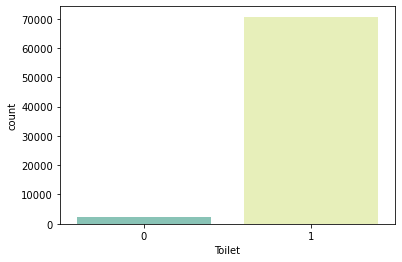

In [12]:
sns.countplot(x = df_daily['Toilet'], palette=["#7fcdbb", "#edf8b1"])

In [13]:
# # Replace 0 with 'F' and 1 with 'T'
# df_daily.replace({0: 'F', 1: 'T'}, inplace=True)

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model
import numpy as np

# Define the input data
data = df_daily[['Breakfast', 'Lunch', 'Dinner', 'Morning_Tea', 'Afternoon_Tea']].values

# Define the target data
target = df_daily['Toilet'].values

# Define the number of previous rows to use for each subnetwork
gluten_lookback = 5
lactose_lookback = 7

# Define the number of future rows to predict
prediction_length = 3

# Create the training dataset
train_data = data[:36500]
train_target = target[:36500]

train_gen_gluten = TimeseriesGenerator(train_data, train_target, length=gluten_lookback+prediction_length, sampling_rate=1, stride=1, batch_size=1)
train_gen_lactose = TimeseriesGenerator(train_data, train_target, length=lactose_lookback+prediction_length, sampling_rate=1, stride=1, batch_size=1)

train_X_gluten = np.array([train_gen_gluten[i][0] for i in range(len(train_gen_gluten))])
train_X_lactose = np.array([train_gen_lactose[i][0] for i in range(len(train_gen_lactose))])
train_y = np.array([train_gen_gluten[i][1][-1] for i in range(len(train_gen_gluten))])

# Create the validation dataset
val_data = data[36500:40150]
val_target = target[36500:40150]

val_gen_gluten = TimeseriesGenerator(val_data, val_target, length=gluten_lookback+prediction_length, sampling_rate=1, stride=1, batch_size=1)
val_gen_lactose = TimeseriesGenerator(val_data, val_target, length=lactose_lookback+prediction_length, sampling_rate=1, stride=1, batch_size=1)

val_X_gluten = np.array([val_gen_gluten[i][0] for i in range(len(val_gen_gluten))])
val_X_lactose = np.array([val_gen_lactose[i][0] for i in range(len(val_gen_lactose))])
val_y = np.array([val_gen_gluten[i][1][-1] for i in range(len(val_gen_gluten))])

# Define the input layers for each subnetwork
gluten_input = Input(shape=(gluten_lookback+prediction_length, 3))
lactose_input = Input(shape=(lactose_lookback+prediction_length, 2))

# Define the gluten subnetwork
gluten_output = LSTM(1)(gluten_input)

# Define the lactose subnetwork
lactose_output = LSTM(1)(lactose_input)

# Concatenate the outputs of the subnetworks
concatenated = Concatenate()([gluten_output, lactose_output])

# Define the output layer
output = Dense(1, activation='sigmoid')(concatenated)

# Create the model
model = Model(inputs=[gluten_input, lactose_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit([train_X_gluten, train_X_lactose], train_y, validation_data=([val_X_gluten, val_X_lactose], val_y), epochs=10)

# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on test data
test_data = data[40150:]
test_target = target[40150:]

test_gen_gluten = TimeseriesGenerator(test_data, test_target, length=gluten_lookback+prediction_length, sampling_rate=1, stride=1, batch_size=1)
test_gen_lactose = TimeseriesGenerator(test_data, test_target, length=lactose_lookback+prediction_length, sampling_rate=1, stride=1, batch_size=1)

test_X_gluten = np.array([test_gen_gluten[i][0] for i in range(len(test_gen_gluten))])
test_X_lactose = np.array([test_gen_lactose[i][0] for i in range(len(test_gen_lactose))])
test_y = np.array([test_gen_gluten[i][1][-1] for i in range(len(test_gen_gluten))])

# Adjust the number of samples to match between subnetworks
num_samples = min(test_X_gluten.shape[0], test_X_lactose.shape[0])
test_X_gluten = test_X_gluten[:num_samples]
test_X_lactose = test_X_lactose[:num_samples]
test_y = test_y[:num_samples]

loss, accuracy = model.evaluate([test_X_gluten, test_X_lactose], test_y)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)


ValueError: Data cardinality is ambiguous:
  x sizes: 36492, 36490
  y sizes: 36492
Make sure all arrays contain the same number of samples.

In [ ]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

gluten_data = df_daily[['Breakfast', 'Lunch', 'Dinner']].values[:36500]
lactose_data = df_daily[['Morning_Tea', 'Afternoon_Tea']].values[:36500]
targets = df_daily['Toilet'].values[3:36503]  # shift targets 3 days later

gluten_sequence_length = 5
lactose_sequence_length = 7
target_length = 3

gluten_dataset = timeseries_dataset_from_array(
    data=gluten_data,
    targets=targets,
    sequence_length=gluten_sequence_length,
    sequence_stride=1,
    batch_size=128,
)

lactose_dataset = timeseries_dataset_from_array(
    data=lactose_data,
    targets=targets,
    sequence_length=lactose_sequence_length,
    sequence_stride=1,
    batch_size=128,
)

# Create validation datasets
gluten_data_val = df_daily[['Breakfast', 'Lunch', 'Dinner']].values[36500:36500+3650]
lactose_data_val = df_daily[['Morning_Tea', 'Afternoon_Tea']].values[36500:36500+3650]
targets_val = df_daily['Toilet'].values[36500+3:36500+3650+3]  # shift targets 3 days later

gluten_val_dataset = timeseries_dataset_from_array(
    data=gluten_data_val,
    targets=targets_val,
    sequence_length=gluten_sequence_length,
    sequence_stride=1,
    batch_size=128,
)

lactose_val_dataset = timeseries_dataset_from_array(
    data=lactose_data_val,
    targets=targets_val,
    sequence_length=lactose_sequence_length,
    sequence_stride=1,
    batch_size=128,
)


In [ ]:
from tensorflow.keras.layers import Input, Dense, LSTM, Concatenate
from tensorflow.keras.models import Model

# Define the sub-networks
gluten_input = Input(shape=(gluten_sequence_length,3), name='gluten_input') 
lactose_input = Input(shape=(lactose_sequence_length,2), name='lactose_input')

gluten_model = LSTM(50, return_sequences=True)(gluten_input)
gluten_model = LSTM(25)(gluten_model)

lactose_model = LSTM(50, return_sequences=True)(lactose_input)
lactose_model = LSTM(25)(lactose_model)

# Concatenate the outputs of the two subnetworks
concat = Concatenate()([gluten_model, lactose_model])

# Define the final Dense layer and the Model
output = Dense(1, activation='sigmoid')(concat)
model = Model(inputs=[gluten_input, lactose_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model
model.summary()


In [ ]:
# Combine the gluten and lactose datasets
train_dataset = tf.data.Dataset.zip((gluten_dataset, lactose_dataset))
val_dataset = tf.data.Dataset.zip((gluten_val_dataset, lactose_val_dataset))

# Define callbacks (optional)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')

# Fit the model
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[early_stopping])
